In [134]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt

### Initial Conditions

In [155]:
S0 = 0.9
I0 = 1
R0 = 2.20

#beta = 0.3 # The parameter controlling how often a susceptible-infected contact results in a new infection.
#gamma = 0.1 # The rate an infected recovers and moves into the resistant phase.
#sigma = 0.1 # The rate at which an exposed person becomes infective.


InterventionTime = 100
OMInterventionAmt = 2/3
InterventionAmt = 1 - OMInterventionAmt

CFR = 0.02 # Case Fatality Rate

P_SEVERE = 0.2 #Hospitalization Rate 

Time_to_death = 32 # Time from end of incubation to death.

D_incbation = 5.2 #Length of incubation period
D_infectious = 2.9 # Duration patient is infectious
D_recovery_mild   = (14 - 2.9)  # Recovery time for mild cases
D_recovery_severe = (31.5 - 2.9) # Recovery time for severe Cases - Length of hopital Stay
D_hospital_lag = 5 # Time to hospitalization.
D_death = Time_to_death - D_infectious 

daysTotal = 360 # total days to model
days0 = 57  #days before lockdown measures

population = 7000000

E0 = 1  # exposed at initial time step
duration = 20




### SIR MODEL

In [156]:
  def model(y, t, N):
    # :param array t: Time step (days)
    # :param int N: Population
    # :param float beta: The parameter controlling how often a susceptible-infected contact results in a new infection.
    # :param float gamma: The rate an infected recovers and moves into the resistant phase.
    # :param float sigma: The rate at which an exposed person becomes infective.
    
    # Beta, Gamma and Sigma calculation
    if t > InterventionTime:
        beta = InterventionAmt * R0/ D_infectious
    else:
        beta = R0/D_infectious
      
    sigma = 1/D_incbation
    gamma = 1/D_infectious
    
    # S = Susceptible
    # E = Exposed
    # I = Infectious
    # Mild - Recovering (Mild)     
    # Severe -  Recovering (Severe at home)
    # Severe_H - Recovering (Severe in hospital)
    # Fatal - Recovering (Fatal)
    # R_Mild - Recovered
    # R_Severe - Recovered
    # R_Fatal - Dead
    S, E, I, R, Mild, Severe, Severe_H, Fatal, R_Mild, R_Severe, R_Fatal  = y
    
    p_severe = P_SEVERE
    p_fatal  = CFR
    p_mild   = 1 - P_SEVERE - CFR

    #beta = beta0 if x < days0 else beta1
    
    dS = - beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    
    dMild     =  p_mild*gamma*I   - (1/D_recovery_mild)*Mild
    dSevere   =  p_severe*gamma*I - (1/D_hospital_lag)*Severe
    dSevere_H =  (1/D_hospital_lag)*Severe - (1/D_recovery_severe)*Severe_H
    dFatal    =  p_fatal*gamma*I  - (1/D_death)*Fatal
    dR_Mild   =  (1/D_recovery_mild)*Mild
    dR_Severe =  (1/D_recovery_severe)*Severe_H
    dR_Fatal  =  (1/D_death)*Fatal
    
    return ([dS, dE, dI, dR, dMild, dSevere, dSevere_H, dFatal, dR_Mild, dR_Severe, dR_Fatal])
    

### SOLVE SIR MODEL

In [157]:
def solve(model, population, E0):
    X = np.arange(daysTotal)  # time steps array
    N0 = population - E0, E0, 0, 0, 0, 0, 0, 0, 0, 0, 0  # S, E, I, R at initial step

    y_data_var = scipy.integrate.odeint(model, N0, X, args=(population,))

    S, E, I, R, Mild, Severe, Severe_H, Fatal, R_Mild, R_Severe, R_Fatal = y_data_var.T  # transpose and unpack
    return X, S, E, I, R, Mild, Severe, Severe_H, Fatal, R_Mild, R_Severe, R_Fatal

In [158]:
X, S, E, I, R, Mild, Severe, Severe_H, Fatal, R_Mild, R_Severe, R_Fatal = solve(model, population, 1)
Hospitalized = numpy.array([Severe_H, Fatal]).sum(axis=0)

Peak day is [128] With  48429.17603792839 Hospitalized


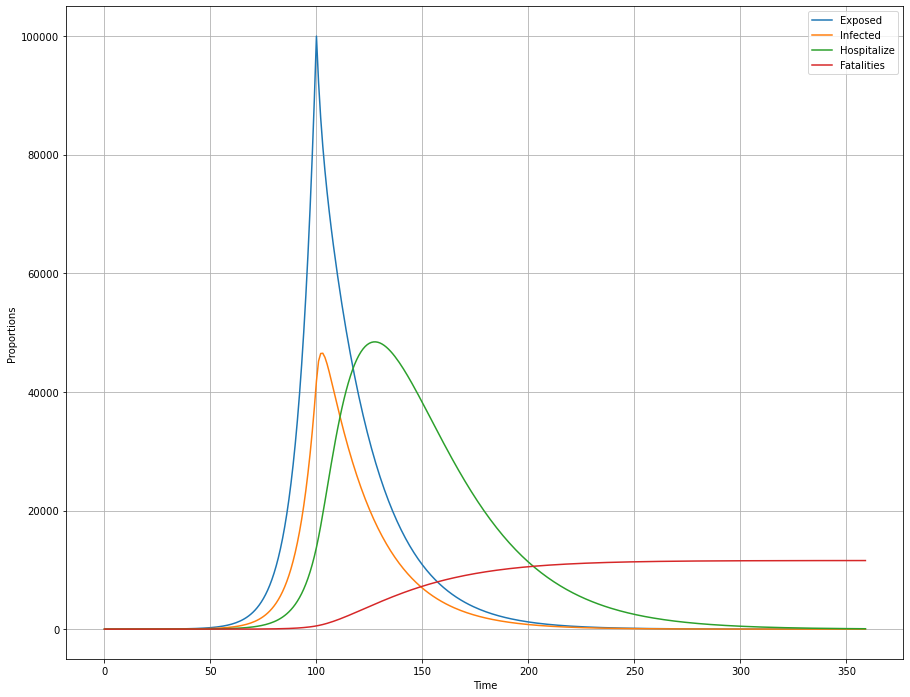

In [159]:
peak = numpy.amax(Hospitalized)
day = numpy.where(Hospitalized == peak)
print('Peak day is', day[0], 'With ', peak, 'Hospitalized')

plt.figure(figsize=[15,12])
#plt.plot(X,S, label="Susceptible")
plt.plot(X,E, label="Exposed")
plt.plot(X,I, label="Infected")
#plt.plot(X,R, label="Recovered with immunity")
plt.plot(X, Hospitalized , label="Hospitalized")
plt.plot(X, R_Fatal , label="Fatalities")


plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportions")
plt.show()

